In [1]:
import numpy as np
from groundlight import Groundlight
import glob
import cv2
import matplotlib.pyplot as plt
import os

In [2]:
# Load the API client. This defaults to the prod endpoint,
# but you can specify a different endpoint like so:
#gl = Groundlight(endpoint="https://device.integ.positronix.ai/device-api")

GROUNDLIGHT_API_TOKEN = 'api_2Au8NPiTMbSLQ73Vjr2eMhX2qUh_pt4EEKhtDNgnjN3dUAr89YANDcYsmBkJZV'

gl = Groundlight(api_token=GROUNDLIGHT_API_TOKEN)

# Call an API method (e.g., retrieve a list of detectors)
detectors = gl.list_detectors()

det = detectors.results[1]

In [3]:
rootDir = '/Users/agoutam/Documents/groundlight/glAPI/'

In [38]:
def sweepLocalize(det, imgDir, imgName):
    
    img = cv2.imread(imgDir + imgName)
    print(imgDir + imgName)
    print(img.shape)
    
    imgDims = np.array([img.shape[1],img.shape[0]])
    
    if imgDims[0] < 20 or imgDims[1] < 20:
        return None
    
    kernelDims = (imgDims*2/3).astype(int)
    sweepDims = (imgDims/4).astype(int)
    colSweeps, rowSweeps = np.round(imgDims/sweepDims).astype(int) - 1
    for col in range(colSweeps):
        for row in range(rowSweeps):
            pxStart = sweepDims * np.array([col, row])
            pxEnd = pxStart + kernelDims
            sliceImg = img[pxStart[1]:pxEnd[1],pxStart[0]:pxEnd[0],:]
            
            sliceName = 'sliceImg-{}{}.jpg'.format(col,row)
            cv2.imwrite(imgDir + sliceName,sliceImg)
            image_query = gl.submit_image_query(detector_id=det.id, image = imgDir + sliceName)
            if image_query.result.label == 'PASS' and image_query.result.confidence > 0.65:
                
                plt.imshow(cv2.cvtColor(sliceImg, cv2.COLOR_RGB2BGR))
                plt.show()
                print(sliceName)
                return (pxStart, np.minimum(pxEnd, imgDims), sweepLocalize(det, imgDir, sliceName))
    return None

In [34]:
def assemblePxTree(oldPx, tree):
    newPx = oldPx + tree[0]
    if(tree[2]) is None:
        newPx += ((tree[1] - tree[0])/2).astype(int)
        return newPx
    return assemblePxTree(newPx, tree[2])

GLIMG/handColorImage.jpg
(480, 640, 3)


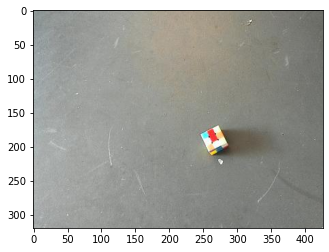

sliceImg-handColorImage-01.jpg
GLIMG/sliceImg-handColorImage-01.jpg
(320, 426, 3)


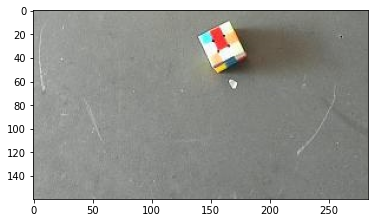

sliceImg-sliceImg-handColorImage-01-12.jpg
GLIMG/sliceImg-sliceImg-handColorImage-01-12.jpg
(160, 284, 3)


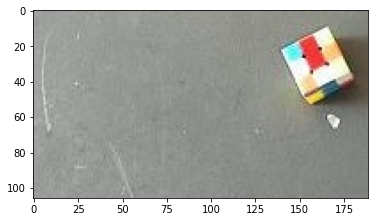

sliceImg-sliceImg-sliceImg-handColorImage-01-12-00.jpg
GLIMG/sliceImg-sliceImg-sliceImg-handColorImage-01-12-00.jpg
(106, 189, 3)


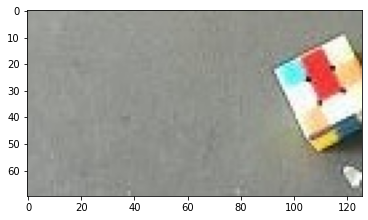

sliceImg-sliceImg-sliceImg-sliceImg-handColorImage-01-12-00-10.jpg
GLIMG/sliceImg-sliceImg-sliceImg-sliceImg-handColorImage-01-12-00-10.jpg
(70, 126, 3)


In [35]:
# imgDims = np.array([640,480])

# imgDir = 'GLIMG/'
# imgName = 'handColorImage.jpg'
# res = sweepLocalize(imgDir, imgName)

In [9]:
def plotTreeOnImage(tree, img):
    fig, ax = plt.subplots(1,1, figsize = (8,10))
    ax.imshow(img)
    plotTreeOnImageHelper(ax, tree, np.array([0,0]))
    return fig, ax
                           
def plotTreeOnImageHelper(ax, tree, prevPx):
    if tree[2] is None:
        center = prevPx + ((tree[0] + tree[1])/2).astype(int)
        ax.scatter([center[0]], [center[1]], color = 'black')
        return
    ax.scatter([tree[0][0] + prevPx[0]],[tree[0][1]  + prevPx[1]],marker = 'o', s = 20, color = 'magenta')
    ax.scatter([tree[1][0]  + prevPx[0]],[tree[1][1]  + prevPx[1]],marker = 'o', s = 20, color = 'cyan')
    prevPx += tree[0]
    plotTreeOnImageHelper(ax, tree[2], prevPx)

In [10]:
# allCubeImgs = sorted(glob.glob(rootDir + "images/cubes/training/*"))
# imgName = allCubeImgs[10]

In [ ]:
# imgNum = imgName[27:31]

# imgDims = np.array([640,480])

# img = cv2.imread(imgName)
# rszImg = cv2.resize(img,(imgDims[0],imgDims[1]))

# tree = sweepLocalize(rszImg)

# fig, ax = plotTreeOnImage(tree, rszImg)

In [47]:
# sliceName = rootDir + 'images/cubes/slices/196./sliceImg01.jpg'
# image_query = gl.submit_image_query(detector_id=det.id, image = sliceName)